In [23]:
import pyodbc
import pandas as pd
import os
import itertools
import re

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Must run in 32 bit Python

In [24]:
ps_cnxn = pyodbc.connect("Provider=MSDASQL.1;Persist Security Info=True;Extended Properties=&quot;DSN=mypstar;&quot;;Initial Catalog=focus2000")
ps_cursor = ps_cnxn.cursor()

In [25]:
plant_query = '''SELECT ss_hist_base_0.start_time, ss_hist_base_0.mach_name, ss_hist_base_0.gross_pieces, ss_hist_base_0.user_text_1, ss_hist_base_0.user_text_4, ss_hist_base_0.mat_formula, ss_hist_base_0.tool, ss_hist_base_0.std_shot_weight, ss_hist_base_0.act_shot_weight
FROM focus2000.dg_def dg_def_0, focus2000.dg_set dg_set_0, focus2000.ss_hist_base ss_hist_base_0
WHERE dg_def_0.mach_seq = ss_hist_base_0.mach_seq AND dg_set_0.dg_seq = dg_def_0.dg_seq AND ((dg_set_0.dg_name Like 'Team%') AND (ss_hist_base_0.start_time>{ts '2019-01-01 06:00:00'}))'''

In [26]:
%%time
# Pull Raw Data
ps_cursor.execute(plant_query)
rows = ps_cursor.fetchall()
df = pd.DataFrame.from_records(rows,columns = ['start_time','mach_name','gross_pieces','user_text_1','shop_order','resin','tool','std_shot_weight','act_shot_weight'])
df.head()

Wall time: 8.58 s


,start_time,mach_name,gross_pieces,user_text_1,shop_order,resin,tool,std_shot_weight,act_shot_weight
0,2019-01-02 18:00:00,14-N400,3498,R7500,185652,RM129,R7500D,1.7975,0.0
1,2019-01-03 06:00:01,14-N400,4226,R7500,185652,RM129,R7500D,1.7975,0.0
2,2019-01-03 18:00:01,14-N400,128,R7500,185652,RM129,R7500D,1.7975,0.0
3,2019-01-03 19:34:32,14-N400,3424,R7500,185786,RM129,R7500D,1.7975,0.0
4,2019-01-04 06:00:00,14-N400,4286,R7500,185786,RM129,R7500D,1.7975,0.0


In [28]:
print('-*'*5+' Summary Stats '+'-*'*5)
print('Earliest entry = {}'.format(df.start_time.min()))
print('Most Recent entry = {}'.format(df.start_time.max()))
print('Number of entries = {}'.format(df.shape[0]))
print('Number of Shop Orders = {}'.format(len(df.shop_order.unique())))

-*-*-*-*-* Summary Stats -*-*-*-*-*
Earliest entry = 2019-01-02 10:12:53
Most Recent entry = 2021-11-30 06:00:00
Number of entries = 168209
Number of Shop Orders = 4133


In [29]:
%%time
df_clean = pd.DataFrame()
for so, frame in df.groupby(by = 'shop_order'):
    if re.match('[0-9]*6',so) is None: continue
    elif len(so) != 6: continue
    df_clean.loc[so,'tool']      = frame['tool'].iloc[0]
    df_clean.loc[so,'mach_name'] = frame['mach_name'].iloc[0]
    df_clean.loc[so,'resin']     = frame['resin'].iloc[0]
    df_clean.loc[so,'total_pieces'] = sum(frame['gross_pieces'])
    df_clean.loc[so,'start_time']= frame['start_time'].min()
    df_clean.loc[so,'end_time']  = frame['start_time'].max()
    df_clean.loc[so,'number of entries'] = len(frame)
df_clean = df_clean.reset_index()\
                    .rename(columns = {'index':'shop_order'})\
                    .sort_values(by = 'start_time')\
                    .reset_index(drop = True)
print('Number of Shop Orders = {}'.format(len(df_clean.shop_order.unique())))
df_clean.head()

Number of Shop Orders = 1405
Wall time: 5.06 s


,shop_order,tool,mach_name,resin,total_pieces,start_time,end_time,number of entries
0,185642,R7024L,65-T310,RM171,78654.0,2019-01-02 10:12:53,2019-01-21 14:00:00,59.0
1,185463,R7450A,91-T180,RM171,4217217.0,2019-01-02 10:26:01,2019-01-13 18:00:01,20.0
2,185596,R7479C-Thin-Wall,54-H1100,RM165,16604.0,2019-01-02 14:00:00,2019-01-08 22:00:00,20.0
3,186266,R7036E-Thin-Wall,74-H650,RM129,1100.0,2019-01-02 14:00:00,2019-01-02 14:00:00,1.0
4,184693,R7605D,83-T390,RM171,147572.0,2019-01-02 14:00:00,2019-01-23 06:00:00,126.0


In [7]:
df_clean.to_csv('./clean_data/plant_star.csv')

In [31]:
resin_v_tool = pd.crosstab(df_clean.tool,df_clean.resin)

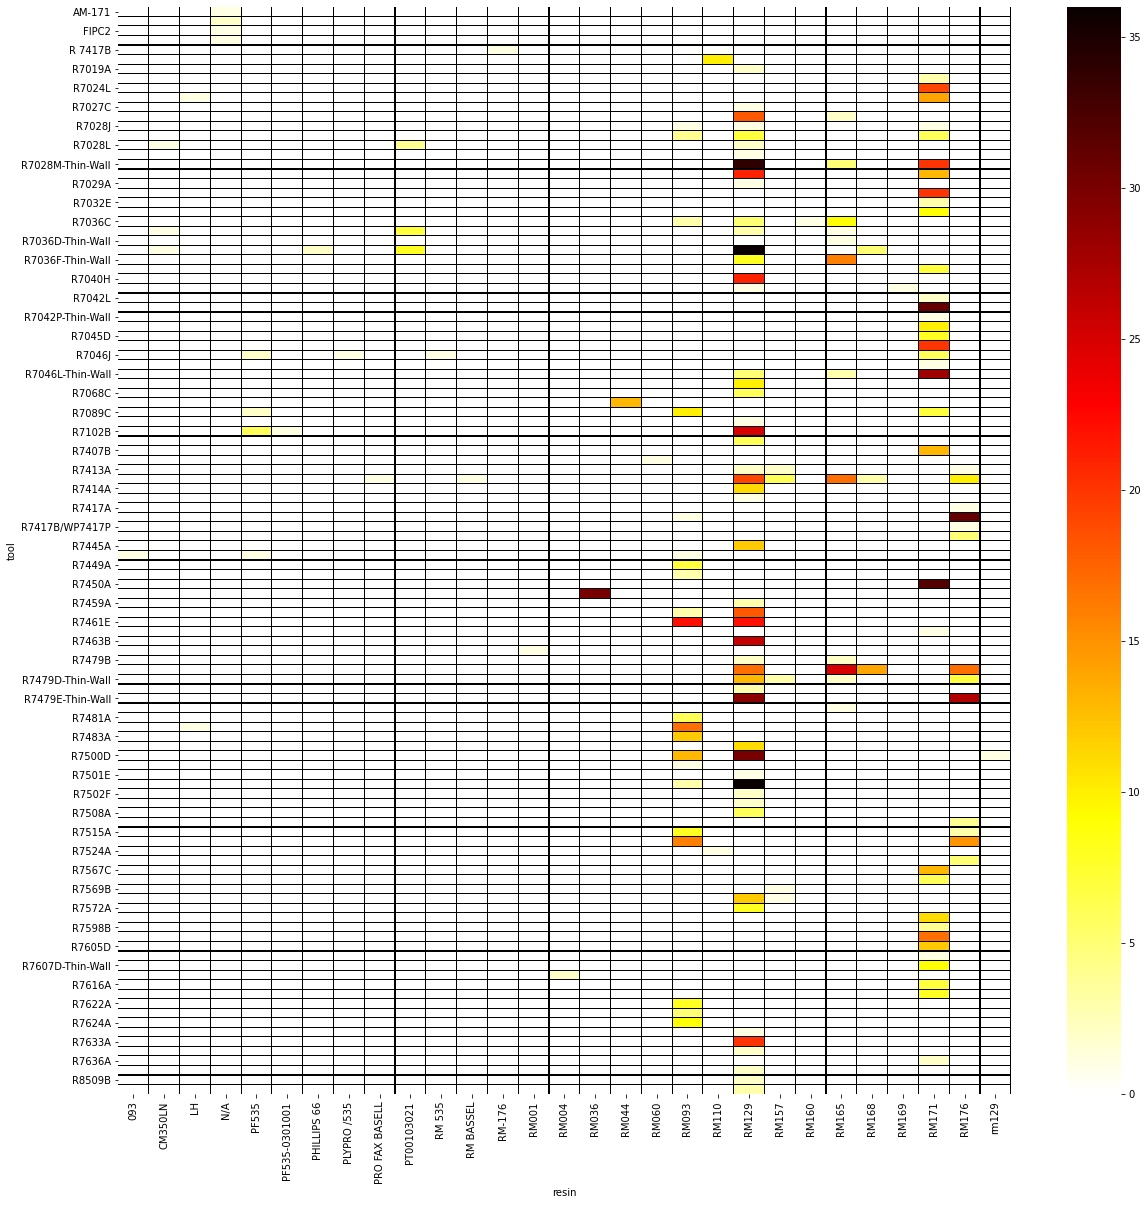

Wall time: 3.35 s


In [32]:
%%time
plt.figure(figsize = (20,20))
sns.heatmap(resin_v_tool,linewidths=.1,linecolor='black',cmap="hot_r")
plt.show()

In [10]:
resin_v_tool_c = resin_v_tool.copy()
resin_v_tool_c.loc[:,'number of resins'] = 0
resin_v_tool_c = resin_v_tool_c.reset_index()
for i in range(len(resin_v_tool)):
    resin_v_tool_c.loc[i,'number of resins'] = sum(resin_v_tool.iloc[i] != 0)


<Figure size 360x1440 with 0 Axes>

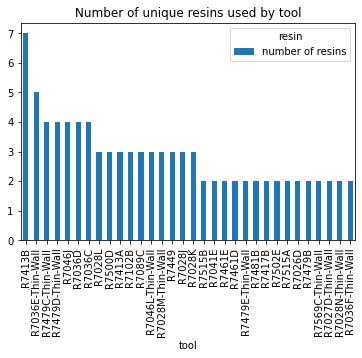

In [30]:
plt.figure(figsize = (5,20))
resin_v_tool_c[['tool','number of resins']].sort_values(by = 'number of resins', ascending = False)[0:32].plot(kind = 'bar',x = 'tool')
plt.title('Number of unique resins used by tool')
plt.show()

In [33]:
tool_v_mach = pd.crosstab(df.tool,df.mach_name)

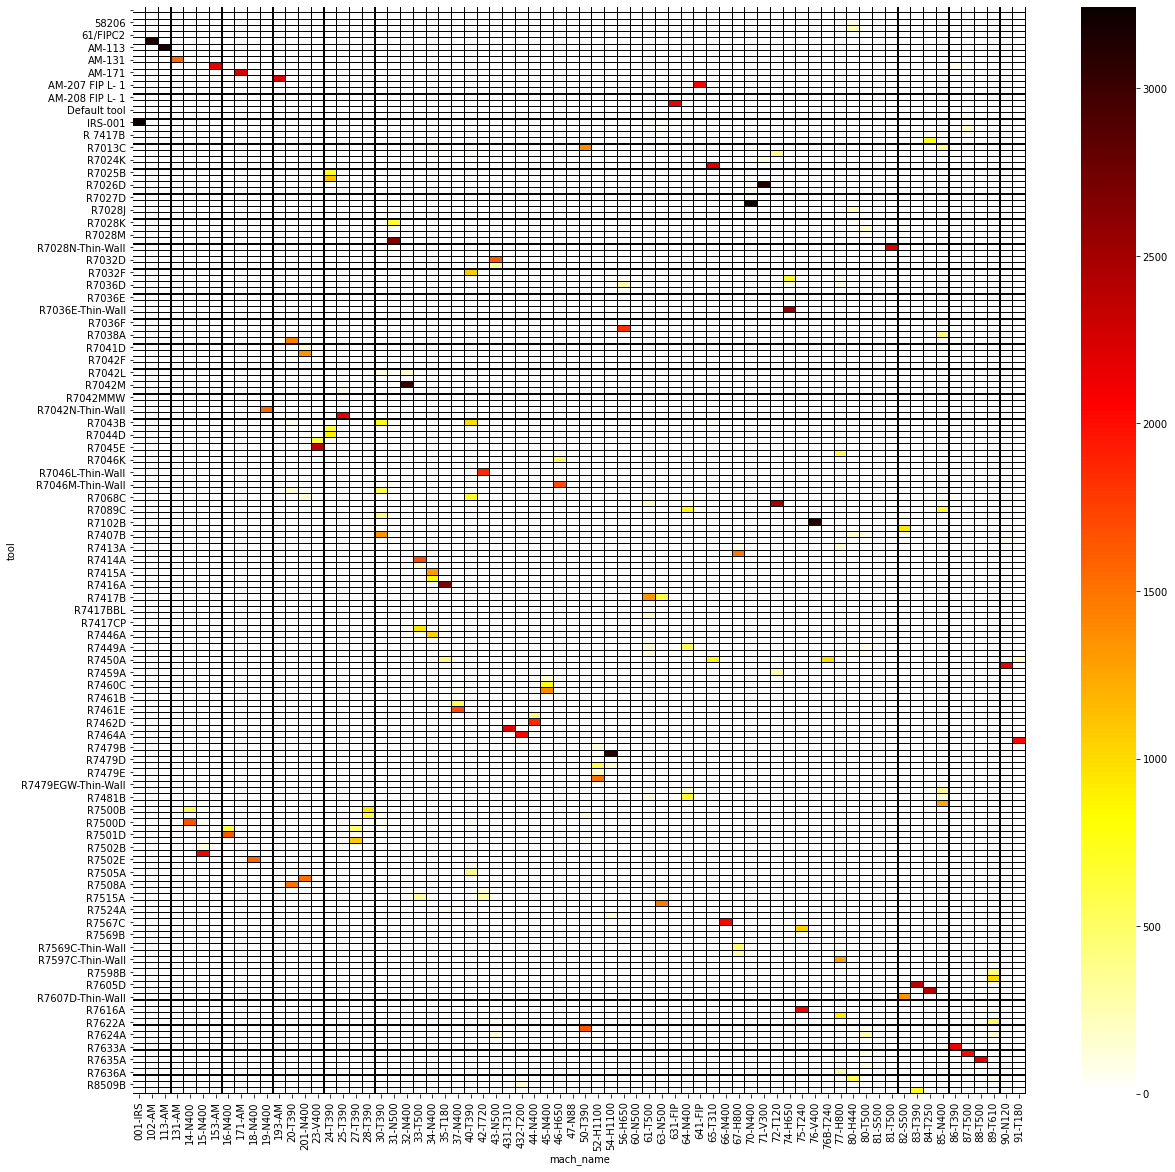

Wall time: 7.39 s


In [34]:
%%time
plt.figure(figsize = (20,20))
sns.heatmap(tool_v_mach,linewidths=.1,linecolor='black',cmap="hot_r")
plt.show()